## Imports

In [1]:
import copy
import numpy as np
import torch
import torch.optim as optim
from sklearn.model_selection import train_test_split
from config import config
import os
import sys
from lime.lime_tabular import LimeTabularExplainer
import shap
current_dir = os.getcwd()
path = "C:\\Users\\eirik\\Documents\\Master\\ISLBBNN\\islbbnn"
# path = "/Users/eirikhoyheim/local_files/master/ISLBBNN/islbbnn"
# path = "C:\\you\\path\\to\\islbbnn\\folder\\here"
os.chdir(path)
import plot_functions as pf
import pipeline_functions as pip_func
sys.path.append('networks')
from lrt_net import BayesianNetwork
import torch.nn.functional as F

os.chdir(current_dir) # set the working directory back to this one 

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Problem description

Problem:

$$y = x_1 + x_2 + x_1\cdot x_2 + x_1^2 + x_2^2 + 100 +\epsilon$$

where $\epsilon \sim N(0,0.01)$. 


Can make $x_3$ dependent on $x_1$. The depedence is defined in the following way:

\begin{align*}
 x_1 &\sim Unif(-10,10) \\
 x_3 &\sim Unif(-10,10) \\
 x_3 &= \text{dep}\cdot x_1 + (1-\text{dep})\cdot x_3
\end{align*}

## Batch size and parameters

In [2]:
# define parameters
HIDDEN_LAYERS = config['n_layers'] - 2 
epochs = config['num_epochs']
post_train_epochs = config['post_train_epochs']
dim = config['hidden_dim']
num_transforms = config['num_transforms']
n_nets = config['n_nets']
n_samples = config['n_samples']
lr = config['lr']
class_problem = config["class_problem"]
non_lin = config["non_lin"]
verbose = config['verbose']
save_res = config['save_res']
patience = config['patience']
SAMPLES = 1




# Define BATCH sizes
BATCH_SIZE = int((n_samples*0.8)/100)
TEST_BATCH_SIZE = int(n_samples*0.10) # Would normally call this the "validation" part (will be used during training)
VAL_BATCH_SIZE = int(n_samples*0.10) # and this the "test" part (will be used after training)

TRAIN_SIZE = int((n_samples*0.80)/100)
TEST_SIZE = int(n_samples*0.10) # Would normally call this the "validation" part (will be used during training)
VAL_SIZE = int(n_samples*0.10) # and this the "test" part (will be used after training)

NUM_BATCHES = TRAIN_SIZE/BATCH_SIZE

print(NUM_BATCHES)

assert (TRAIN_SIZE % BATCH_SIZE) == 0
assert (TEST_SIZE % TEST_BATCH_SIZE) == 0

1.0


# ReLU based network

## Seperate a test set for later

In [3]:
# Get linear data
y, X = pip_func.create_data_unif(n_samples, beta=[100,1,1,1,1], dep_level=0.0, classification=class_problem, non_lin=non_lin)

n, p = X.shape  # need this to get p 
print(n,p,dim)

# Split keep some of the data for validation after training
X, X_test, y, y_test = train_test_split(
    X, y, test_size=0.10, random_state=42)#, stratify=y)

test_dat = torch.tensor(np.column_stack((X_test,y_test)),dtype = torch.float32)

40000 4 20


## Train, validate, and test model

In [4]:
# select the device and initiate model

# DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "mps")
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}

all_nets = {}
metrics_several_runs = []
metrics_median_several_runs = []
for ni in range(n_nets):
    post_train = False
    print('network', ni)
    # Initate network
    torch.manual_seed(ni+42)
    #---------------------------
    # DIFFERENCE IS IN act_func=F.relu part
    net = BayesianNetwork(dim, p, HIDDEN_LAYERS, classification=class_problem, act_func=F.relu).to(DEVICE)
    #---------------------------
    alphas = pip_func.get_alphas_numpy(net)
    nr_weights = np.sum([np.prod(a.shape) for a in alphas])
    print(nr_weights)

    optimizer = optim.Adam(net.parameters(), lr=lr)
    
    all_nll = []
    all_loss = []

    # Split into training and test set
    X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=1/9, random_state=ni)#, stratify=y)
            
    train_dat = torch.tensor(np.column_stack((X_train,y_train)),dtype = torch.float32)
    val_dat = torch.tensor(np.column_stack((X_val,y_val)),dtype = torch.float32)
    
    # Train network
    counter = 0
    highest_acc = 0
    best_model = copy.deepcopy(net)
    for epoch in range(epochs + post_train_epochs):
        if verbose:
            print(epoch)
        nll, loss = pip_func.train(net, train_dat, optimizer, BATCH_SIZE, NUM_BATCHES, p, DEVICE, nr_weights, post_train=post_train)
        nll_val, loss_val, ensemble_val = pip_func.val(net, val_dat, DEVICE, verbose=verbose, reg=(not class_problem))
        if ensemble_val >= highest_acc:
            counter = 0
            highest_acc = ensemble_val
            best_model = copy.deepcopy(net)
        else:
            counter += 1
        
        all_nll.append(nll)
        all_loss.append(loss)

        if epoch == epochs-1:
            post_train = True   # Post-train --> use median model 
            for name, param in net.named_parameters():
                for i in range(HIDDEN_LAYERS+1):
                    #if f"linears{i}.lambdal" in name:
                    if f"linears.{i}.lambdal" in name:
                        param.requires_grad_(False)

        if counter >= patience:
            break
        
    all_nets[ni] = net 
    # Results
    metrics, metrics_median = pip_func.test_ensemble(all_nets[ni], test_dat, DEVICE, SAMPLES=10, reg=(not class_problem)) # Test same data 10 times to get average 
    metrics_several_runs.append(metrics)
    metrics_median_several_runs.append(metrics_median)
    pf.run_path_graph(all_nets[ni], threshold=0.5, save_path=f"path_graphs/lrt/prob/test{ni}_relu_lime_shap", show=verbose)

if verbose:
    print(metrics)
m = np.array(metrics_several_runs)
m_median = np.array(metrics_median_several_runs)

network 0
1544
0
loss 22497.3046875
nll 181.31527709960938
density 0.9987624043241684

val_loss: 24385.0293, val_nll: 2047.1575, val_ensemble: 0.7827, used_weights_median: 1544

1
loss 20731.33984375
nll 124.93897247314453
density 0.9952923953147133

val_loss: 22091.4473, val_nll: 1376.3702, val_ensemble: 0.8425, used_weights_median: 1544

2
loss 18537.31640625
nll 114.58566284179688
density 0.9682472520773275

val_loss: 20243.7969, val_nll: 1137.5875, val_ensemble: 0.8752, used_weights_median: 1544

3
loss 15152.9462890625
nll 94.32264709472656
density 0.8685435285608385

val_loss: 16292.2061, val_nll: 1048.3163, val_ensemble: 0.8800, used_weights_median: 1337

4
loss 10930.41796875
nll 105.44758605957031
density 0.6898157710373556

val_loss: 11722.4287, val_nll: 941.7867, val_ensemble: 0.8965, used_weights_median: 1019

5
loss 7358.0625
nll 92.0932846069336
density 0.5075935237254426

val_loss: 7548.7368, val_nll: 947.6117, val_ensemble: 0.8858, used_weights_median: 646

6
loss 5427.

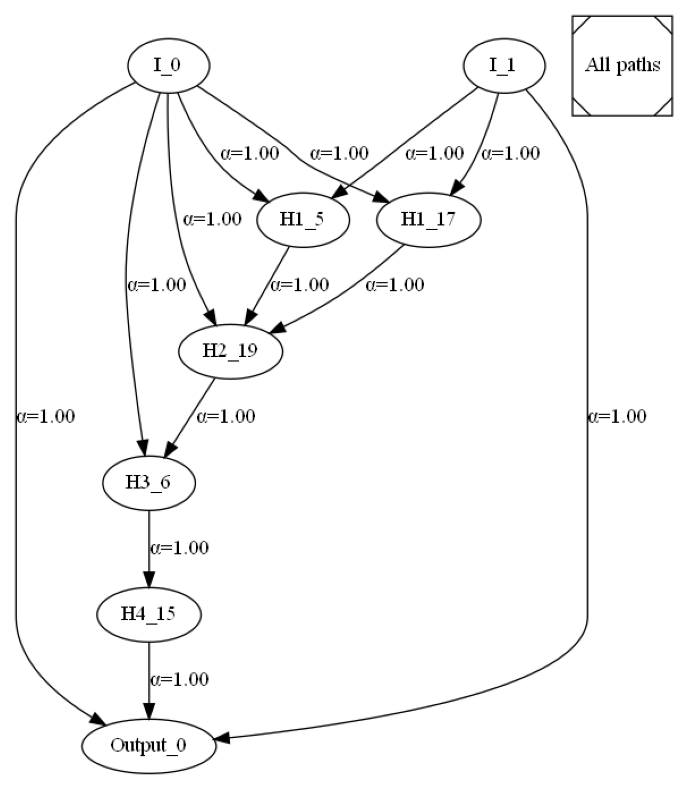

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread("path_graphs/lrt/prob/test0_relu_lime_shap.png")
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(img)
plt.show()

After training:

* 13 weights used in median model $\rightarrow$ density of 0.84% compared to initialized model (1544 weigths) 
* ACC of 94.7\% for median model
* ACC of 93.9\% for full model

## Weight graph

In [6]:
pf.run_path_graph_weight(net, save_path="path_graphs/lrt/weight/temp_relu_lime_shap", show=True)

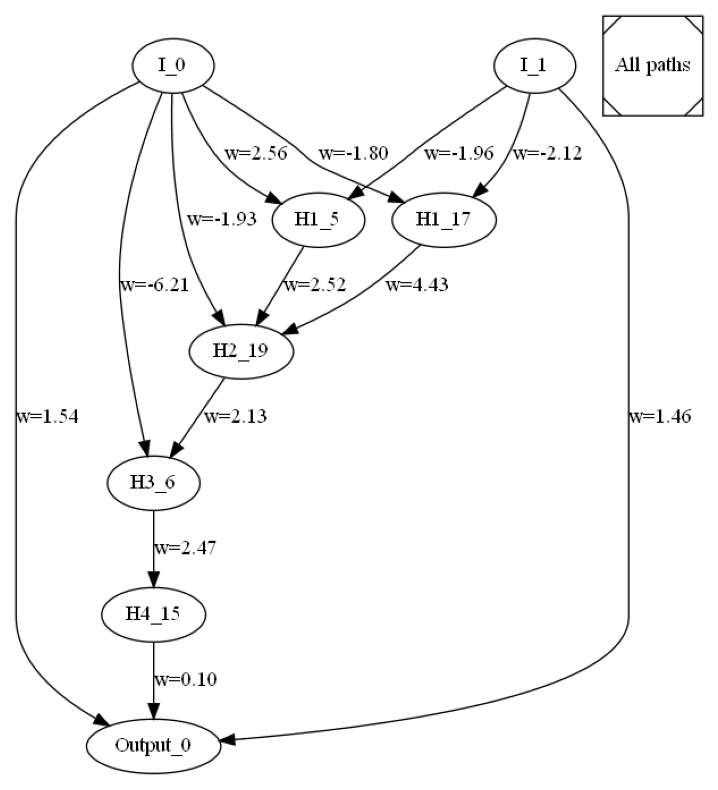

In [7]:
img = mpimg.imread("path_graphs/lrt/weight/temp_relu_lime_shap.png")
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(img)
plt.show()

## Local contribution

### Lime code

In [8]:
# Assuming `net` is your trained PyTorch model and `DEVICE` is your computation device (e.g., 'cpu' or 'cuda')

def batch_predict_lime(x):
    net.eval()
    x = torch.tensor(x, dtype=torch.float32).to(DEVICE)
    if len(x.shape) == 1:
        preds = np.zeros((1000, 1, 2))
    else:
        preds = np.zeros((1000, len(x), 2))
    with torch.no_grad():
        for samp in range(len(preds)):
            preds[samp, :, 1] = net.forward(x, ensemble=False, sample=True).detach().cpu().numpy().T[0]
            preds[samp, :, 0] = 1 - preds[samp, :, 1]
    preds = preds.mean(0)
    return preds

def explain_lime(indx, X_test, feature_names=["x0", "x1", "x2", "x3"], class_names=["Class 0", "Class 1"]):
    # Assuming `X_train` is your training data and `class_names` are the names of the classes
    explainer = LimeTabularExplainer(
        training_data=X_train,
        feature_names=feature_names,
        class_names=class_names,
        mode='classification'
    )
    # Explain a single instance
    exp = explainer.explain_instance(
        data_row=X_test[indx],
        predict_fn=batch_predict_lime,
        num_features=4,  # Number of features to include in the explanation
        num_samples=10_000
    )
    return exp


def plot_lime_explain(exp, indx, class_label=1, names_features=["x0", "x1", "x2", "x3"]):
    # Extract feature importances for a specific class
    feature_importances = dict(exp.as_map()[class_label])

    # Ensure the feature importances are in the correct order
    ordered_importances = [feature_importances[indx] for indx in range(len(names_features))]

    # Create a bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(names_features, ordered_importances, color='skyblue', edgecolor='k')
    plt.ylabel('LIME importance')
    plt.xlabel('Feature')
    plt.title(f'LIME feature importances for Class {class_label} (instance {indx})')
    plt.grid()
    plt.show()

### SHAP code

In [9]:
# Assuming `net` is your trained PyTorch model and `DEVICE` is your computation device (e.g., 'cpu' or 'cuda')

def batch_predict_shap(x):
    net.eval()
    x = torch.tensor(x, dtype=torch.float32).to(DEVICE)
    preds = np.zeros((1000, len(x), 1))
    with torch.no_grad():
        for samp in range(len(preds)):
            preds[samp, :, 0] = net.forward(x, ensemble=False, sample=True).detach().cpu().numpy().T[0]
    preds = preds.mean(0)
    return preds


def shap_explain(X_test, i):
    # Create SHAP explainer
    explainer = shap.Explainer(batch_predict_shap, X_train)
    # Index of the instance you want to explain

    # Explain the instance
    shap_vals = explainer(X_test[i:i+1], max_evals=100_000, batch_size=1000)
    return shap_vals

def plot_shap_explain(shap_vals, i, feature_names = ["x0", "x1", "x2", "x3"]):
    # Plot bar plot of SHAP values
    plt.figure(figsize=(10, 6))
    plt.bar(feature_names, shap_vals.values[0], color='skyblue', edgecolor='k')
    plt.xlabel('Feature')
    plt.ylabel('SHAP value')
    plt.title(f'SHAP values for instance {i}. Baseline: {shap_vals.base_values[0][0]:.4f}')
    plt.grid()
    plt.show()

### Positiv prediction

#### Empirical approach

In [10]:
variable_names=["x0", "x1", "x2", "x3"]

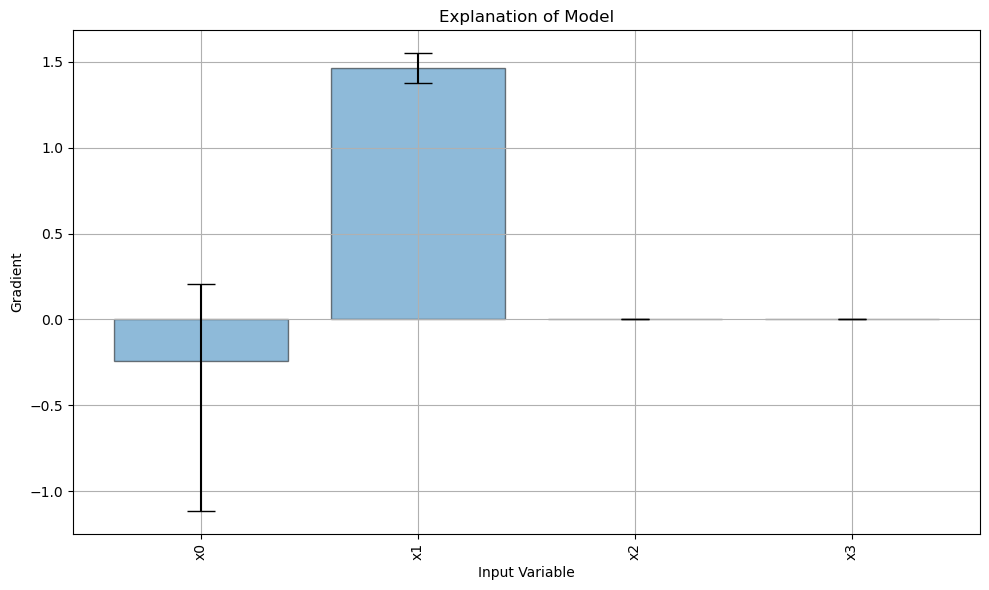

In [11]:
i = 1
n_samples = 10_000
explanation = torch.zeros((n_samples,p))
for j in range(n_samples):
    
    explain_this = test_dat[i,:-1].reshape(-1, p)
    explain_this.requires_grad = True
    net.zero_grad()
    output = net.forward_preact(explain_this, sample=True, ensemble=False)
    output_value = output[0,0]
    output_value.backward()

    gradients = explain_this.grad
    explanation[j] = gradients[0]


# remove variables that does not contribute to the prediction at all
expl = np.where(explain_this[0] != 0.0, explanation.cpu().detach().numpy(), 0)
means = expl.mean(0)

cred_int = np.quantile(expl, [0.025,0.975],axis=0).T
for indx, err in enumerate(cred_int):
    if err[0] == 0 and err[1] == 0:
        err[0] = means[indx]
        err[1] = means[indx]
top = cred_int[:,1]-means
bottom = means-cred_int[:,0]
# Plot the explanation tensor
plt.figure(figsize=(10, 6))
plt.bar(range(p), means, yerr=(bottom, top), align='center', alpha=0.5, edgecolor='k', capsize=10)
plt.xlabel('Input Variable')
plt.ylabel('Gradient')
plt.title('Explanation of Model')
plt.xticks(range(p), [f'{variable_names[i]}' for i in range(p)], rotation=90)  # Rotate x-axis labels if necessary
plt.grid()
plt.tight_layout()
# plt.savefig("imgs/local_explain_grad_based_10.png")
plt.show()

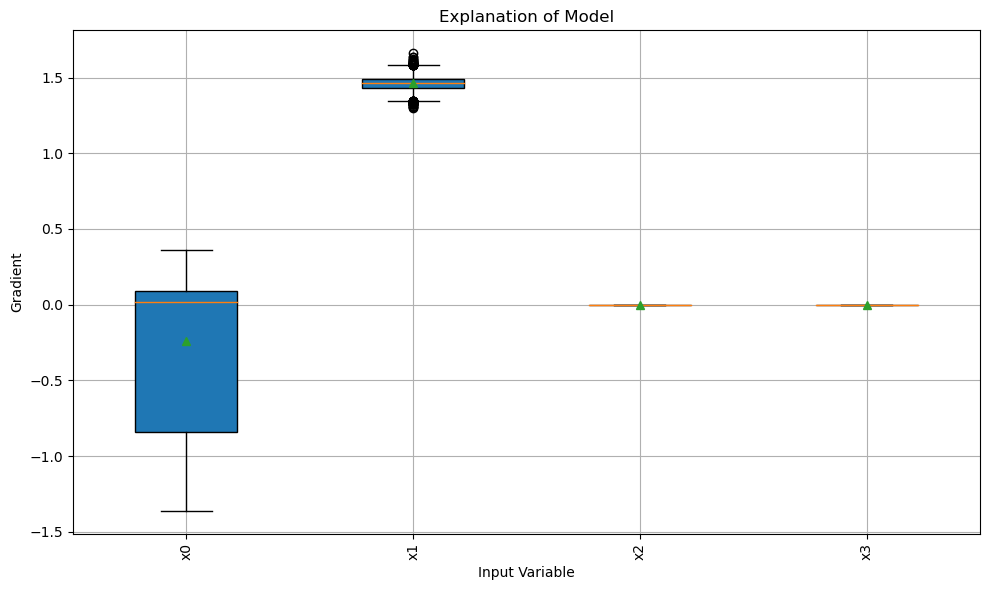

In [12]:
# Plot the explanation tensor as a boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(expl, vert=True, patch_artist=True, showmeans=True)
plt.xlabel('Input Variable')
plt.ylabel('Gradient')
plt.title('Explanation of Model')
plt.xticks(range(1, p + 1), [f'{variable_names[i]}' for i in range(p)], rotation=90)  # Rotate x-axis labels if necessary
plt.grid()
plt.tight_layout()
# plt.savefig("imgs/local_explain_grad_based_10.png")
plt.show()

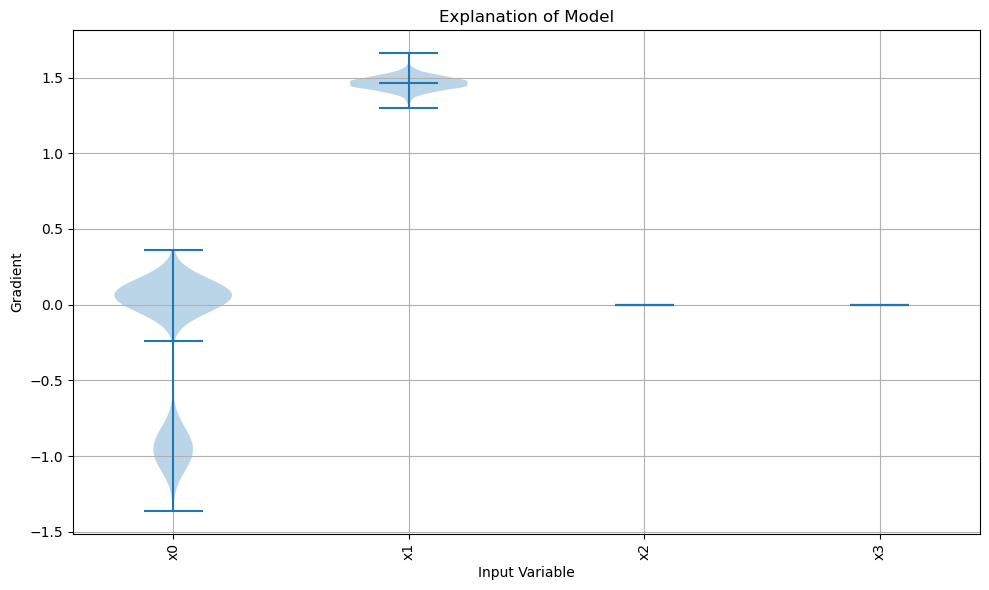

In [13]:
# Plot the explanation tensor as a boxplot
plt.figure(figsize=(10, 6))
plt.violinplot(expl, showmeans=True)
plt.xlabel('Input Variable')
plt.ylabel('Gradient')
plt.title('Explanation of Model')
plt.xticks(range(1, len(variable_names) + 1), variable_names, rotation=90)  # Rotate x-axis labels if necessary
plt.grid()
plt.tight_layout()
# plt.savefig("imgs/local_explain_grad_based_10.png")
plt.show()

True class: 0.0


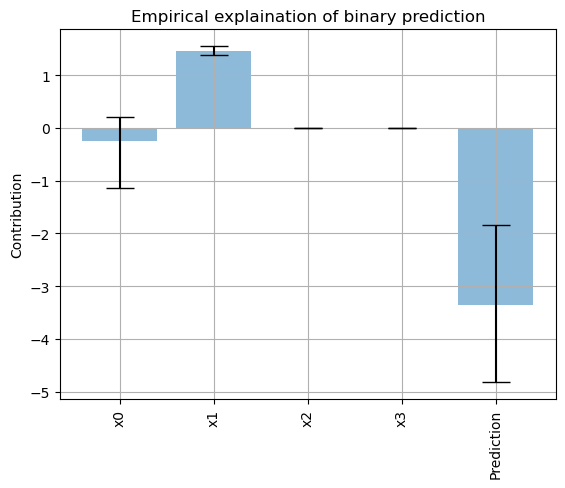

In [17]:
i = 1
explain_this = test_dat[i,:-1].reshape(-1, p)
print(f"True class: {test_dat[i,-1]}")
pf.plot_local_contribution_empirical(net, explain_this, sample=True, median=True, n_samples=2_000, variable_names=["x0", "x1", "x2", "x3"], class_names=["binary prediction"],  magnitude=True, include_bias=False)

True class: 0.0


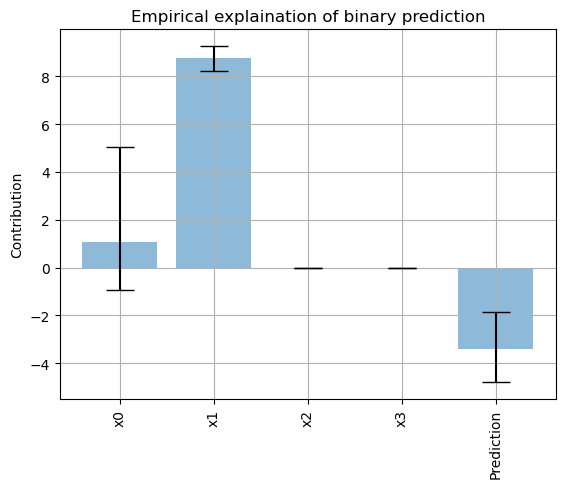

In [16]:
i = 1
explain_this = test_dat[i,:-1].reshape(-1, p)
print(f"True class: {test_dat[i,-1]}")
pf.plot_local_contribution_empirical(net, explain_this, sample=True, median=True, n_samples=2_000, variable_names=["x0", "x1", "x2", "x3"], class_names=["binary prediction"], include_bias=False)

#### LIME explanation

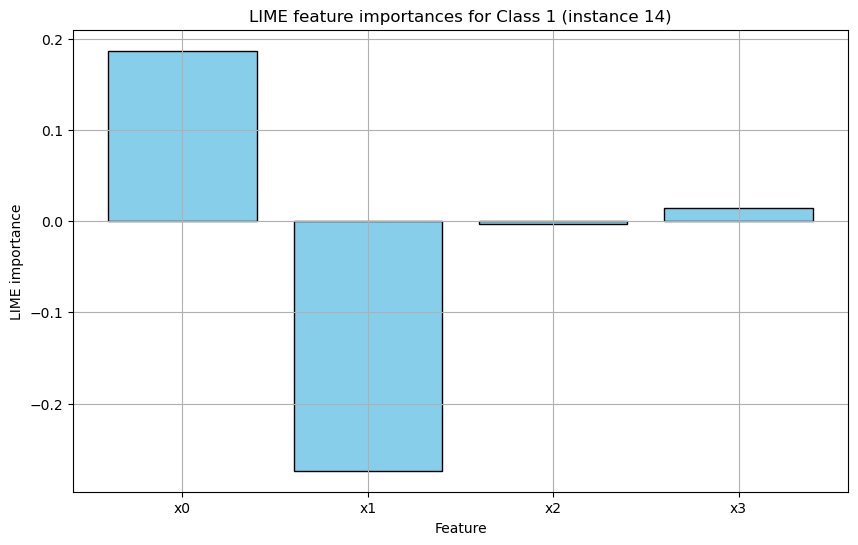

In [11]:
exp = explain_lime(i, X_test)
plot_lime_explain(exp, i)

In [12]:
exp.local_exp[1]

[(1, -0.2734659214998288),
 (0, 0.18666786725307388),
 (3, 0.013821933627203808),
 (2, -0.003397890912461306)]

#### SHAP explanation

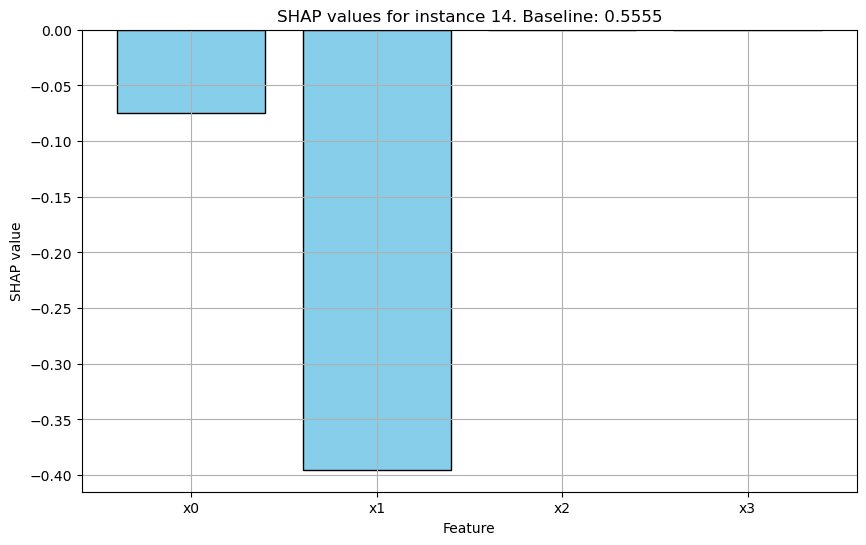

In [13]:
shap_vals = shap_explain(X_test, i)
plot_shap_explain(shap_vals, i)

In [14]:
shap_vals

.values =
array([[-0.0751767 , -0.39515783,  0.        ,  0.        ]])

.base_values =
array([[0.55549364]])

.data =
array([[-7.29701617,  1.9138231 ,  0.09515156,  0.02504306]])

### Negative prediction

#### Empirical explanation

True class: 1.0


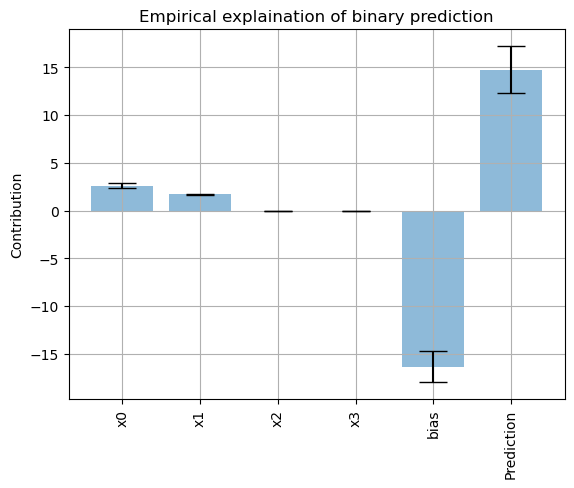

In [ ]:
i = 8
explain_this = test_dat[i,:-1].reshape(-1, p)
print(f"True class: {test_dat[i,-1]}")
pf.plot_local_contribution_empirical(net, explain_this, sample=True, median=True, n_samples=2_000, variable_names=["x0", "x1", "x2", "x3"], class_names=["binary prediction"], magnitude=True)

True class: 1.0


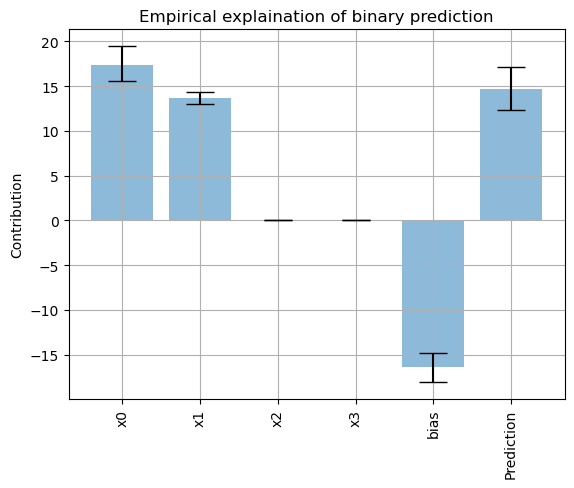

In [26]:
i = 8
explain_this = test_dat[i,:-1].reshape(-1, p)
print(f"True class: {test_dat[i,-1]}")
pf.plot_local_contribution_empirical(net, explain_this, sample=True, median=True, n_samples=2_000, variable_names=["x0", "x1", "x2", "x3"], class_names=["binary prediction"])

#### LIME explanation

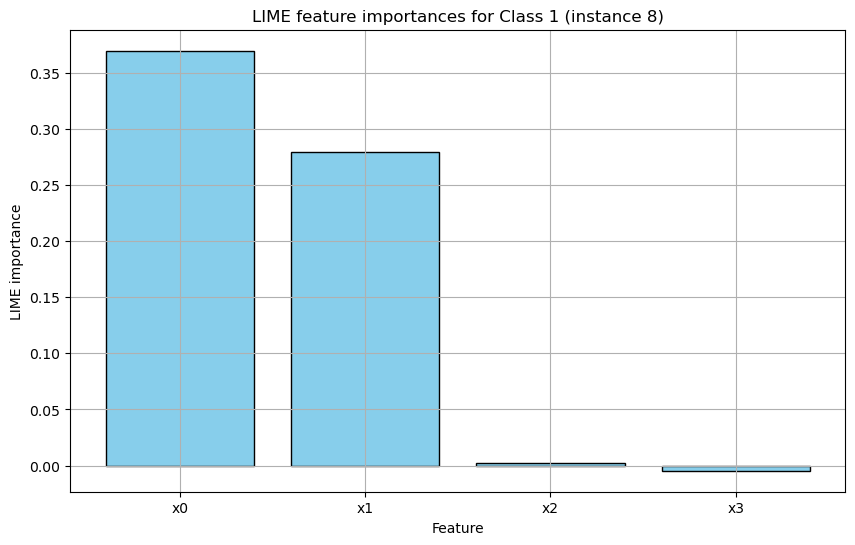

In [16]:
exp = explain_lime(i, X_test)
plot_lime_explain(exp, i)

In [17]:
exp.local_exp[1]

[(0, 0.3695604499631411),
 (1, 0.2797603939862469),
 (3, -0.004575206101869188),
 (2, 0.0019752321663778533)]

#### SHAP explanation

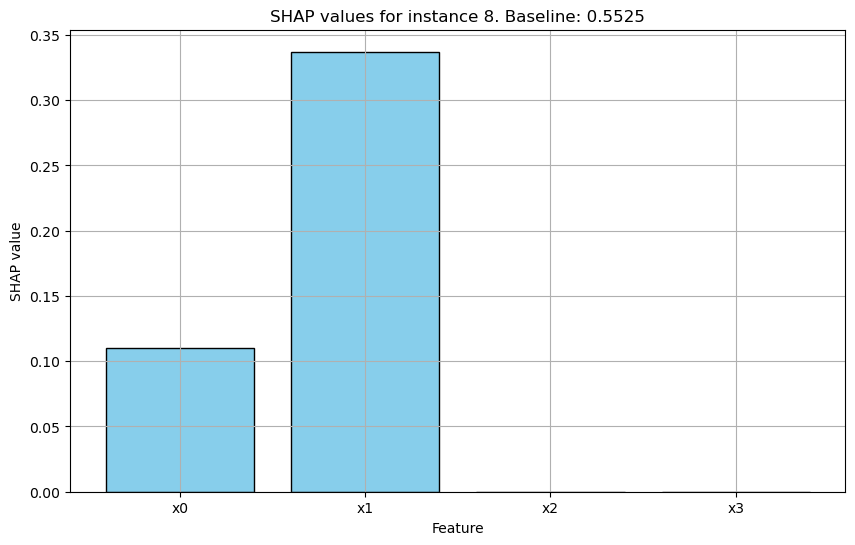

In [18]:
shap_vals = shap_explain(X_test, i)
plot_shap_explain(shap_vals, i)

In [19]:
shap_vals

.values =
array([[1.10368834e-01, 3.37175352e-01, 2.77555756e-17, 0.00000000e+00]])

.base_values =
array([[0.5524549]])

.data =
array([[ 6.71416605,  8.10428467, -8.59457648, -7.49614351]])

### Uncertain prediction

#### Empirical explanation

True class: 0.0


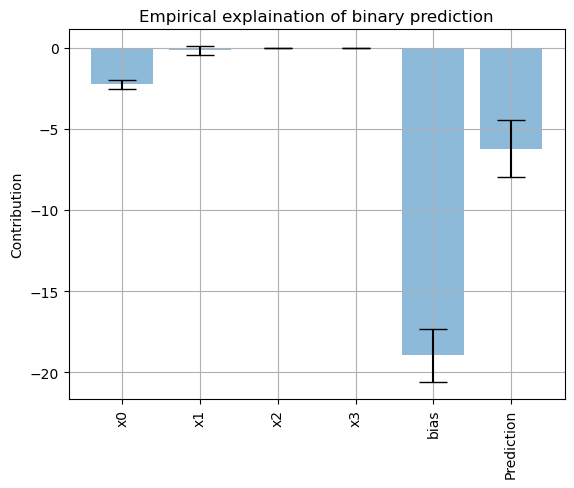

In [ ]:
i = 16
explain_this = test_dat[i,:-1].reshape(-1, p)
print(f"True class: {test_dat[i,-1]}")
pf.plot_local_contribution_empirical(net, explain_this, sample=True, median=True, n_samples=2_000, variable_names=["x0", "x1", "x2", "x3"], class_names=["binary prediction"], magnitude=True)

True class: 0.0


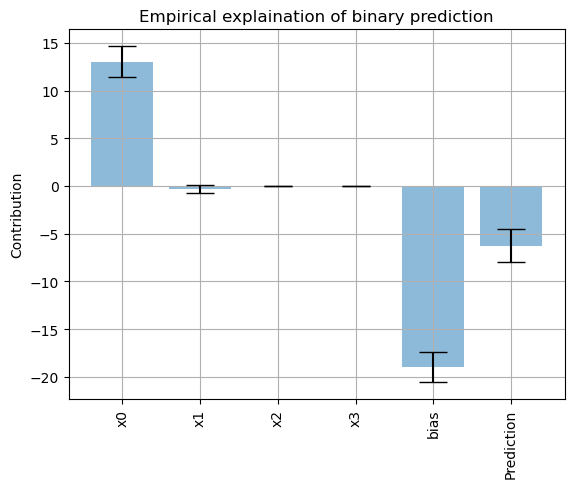

In [27]:
i = 16
explain_this = test_dat[i,:-1].reshape(-1, p)
print(f"True class: {test_dat[i,-1]}")
pf.plot_local_contribution_empirical(net, explain_this, sample=True, median=True, n_samples=2_000, variable_names=["x0", "x1", "x2", "x3"], class_names=["binary prediction"])

#### LIME explanation

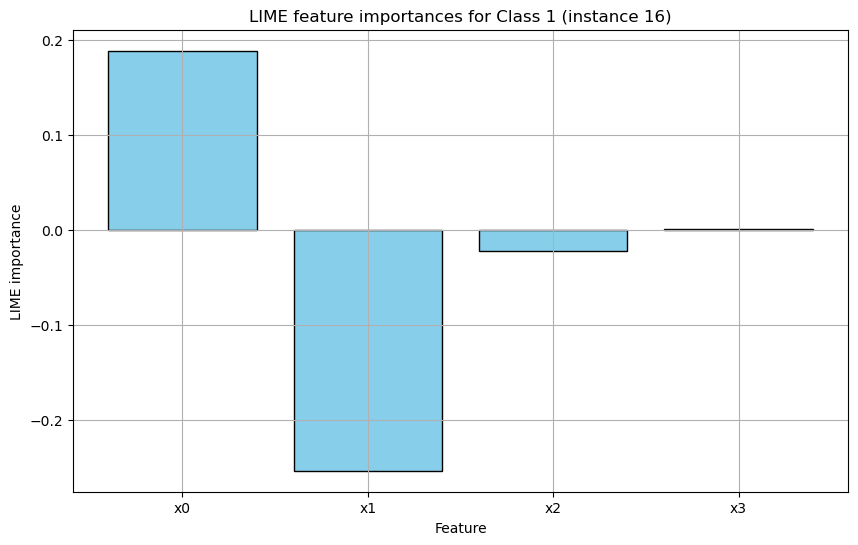

In [21]:
exp = explain_lime(i, X_test)
plot_lime_explain(exp, i)

In [22]:
exp.local_exp[1]

[(1, -0.25367203711456504),
 (0, 0.18845824651604168),
 (2, -0.022462232268824003),
 (3, 0.0011198030383399139)]

#### SHAP explanation

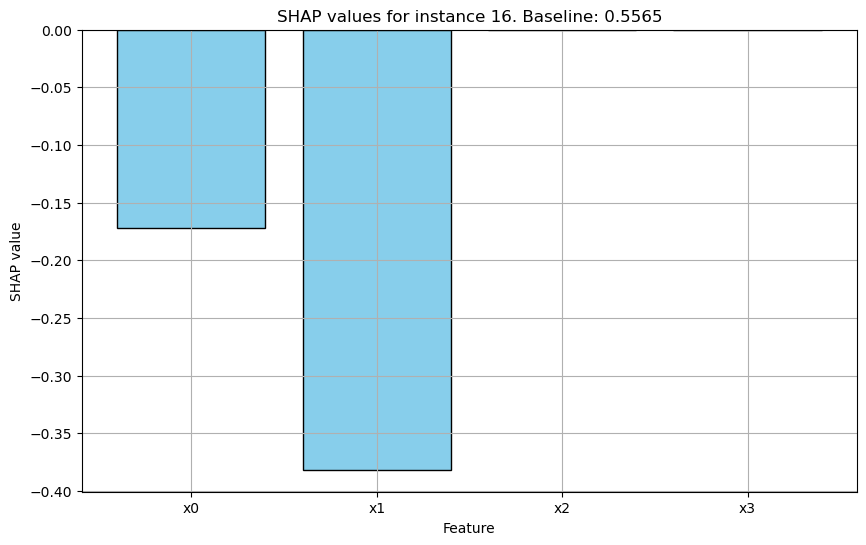

In [23]:
shap_vals = shap_explain(X_test, i)
plot_shap_explain(shap_vals, i)

In [24]:
shap_vals

.values =
array([[-1.71913927e-01, -3.81730889e-01,  2.77555756e-17,
         0.00000000e+00]])

.base_values =
array([[0.55650744]])

.data =
array([[-5.71501933,  1.65381745, -0.17798217, -8.24304405]])